<a href="https://colab.research.google.com/github/mx-drn/bachelor_thesis_pseudo_labeling/blob/main/first_implementation_of_BERT_on_kaggle_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
#!pip install wandb
!pip install easynmt
#!pip install pydeepl

In [2]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

In [3]:
#print(torch.__version__)

In [4]:
# needed imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk
import time
#import wandb
import pickle
from easynmt import EasyNMT
import requests
import copy
import collections
from operator import itemgetter
import pickle

import transformers
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap

from transformers.models.bert.modeling_bert import BertEmbeddings, BertPooler, BertLayer
#import pytorch_lightning as pl

from pylab import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Use GPU
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Thu Aug 12 10:49:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get an Overview over the data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import data
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/kaggle_data.csv", names=['label', 'article'], encoding='latin-1')

print("Overall distribution of the data and labels:")
print(data['label'].value_counts(ascending=True))
print()

all_lens = {
    'positive': [],
    'negative': [],
    'neutral': []
}

for index, row in data.iterrows():
    all_lens[row['label']].append(len(row['article']))
print("General dataset size: " + str(len(data)))

print("\nPositive Sentiment Mean Article Length: " + str(sum(all_lens['positive'])/len(all_lens['positive'])))
print("Positive Sentiment Max Article Length: " + str(max(all_lens['positive'])))
print()
print("Neutral Sentiment Mean Article Length: " + str(sum(all_lens['neutral'])/len(all_lens['neutral'])))
print("Neutral Sentiment Max Article Length: " + str(max(all_lens['neutral'])))
print()
print("Negative Sentiment Mean Article Length: " + str(sum(all_lens['negative'])/len(all_lens['negative'])))
print("Negative Sentiment Max Article Length: " + str(max(all_lens['negative'])))

Overall distribution of the data and labels:
negative     604
positive    1363
neutral     2879
Name: label, dtype: int64

General dataset size: 4846

Positive Sentiment Mean Article Length: 135.64783565663976
Positive Sentiment Max Article Length: 298

Neutral Sentiment Mean Article Length: 125.07224730809308
Neutral Sentiment Max Article Length: 315

Negative Sentiment Mean Article Length: 125.75662251655629
Negative Sentiment Max Article Length: 296


## Have a look at the data

In [8]:
print('Article:')
print(data.iloc[13].article + "\n")
print('Label:')
print(data.iloc[13].label)

Article:
Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .

Label:
positive


In [9]:
label_names = list(set(data['label'].values))
label_names.sort()

print("All possible labels: " + str(label_names))

All possible labels: ['negative', 'neutral', 'positive']


### Test Data if BERT cased or uncased makes sense

In [10]:
uppercased_words_found = []

for index, row in data.iterrows():
    temp_article = row['article']
    
    for word in temp_article:
        if len(word)>1 and word == word.upper():
            uppercased_words_found.append(word)
            
print(uppercased_words_found)

[]


## Preprocessing

In [11]:
# normalize whitespace
data['article'] = data['article'].apply(lambda x: " ".join(x.split()))

# remove punctuations except ?
data['article'] = data['article'].apply(lambda x: re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', x))

## Convert labels to more understandable 0, 1, 2 format

In [12]:
new_labels = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}
for index, row in data.iterrows():
  data['label'].iloc[index] = new_labels[row['label']]
data.head(2)

,label,article
0,1,"According to Gran , the company has no plans..."
1,1,Technopolis plans to develop in stages an area...


## Build Pseudo Labeling Dataset

In [13]:
def get_dataclass_distribution_of_unlabeled_data(data_class_size, X, y, random_state):
  labeled_data_distribution = data_class_size/len(X)

  X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X, y, test_size=labeled_data_distribution, random_state=random_state)
  len(X_labeled)
  return {
      'labeled_data': X_labeled,
      'labeled_data_labels': y_labeled,
      'unlabeled_data': X_unlabeled,
      'unlabeled_data_labels': y_unlabeled
  }

## Set tokenizer

In [14]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
# Uncased -> Because case may express the sentiment but no uppercase word are given in the dataset as mentioned earlier

### Choose maximum token length

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


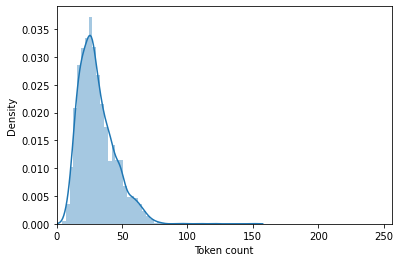

In [15]:
token_lens = []
for txt in data.article:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [16]:
MAX_LEN = 100
BATCH_SIZE = 8
SEED = 1210

# Split data into training and validation datasets

In [17]:
def split_data_into_train_test_val(X, y, val_size, random_state):
    X_reduced, X_test, y_reduced, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, y_reduced, test_size=val_size, random_state=random_state, stratify=y_reduced)
    
    return {
        'train': {
            'X': list(X_train),
            'y': list(y_train)
        },
        'val': {
            'X': list(X_val),
            'y': list(y_val)
        },
        'test': {
            'X': list(X_test),
            'y': list(y_test)
        }
    }

In [18]:
split_data = split_data_into_train_test_val(data['article'].values, data['label'].values, val_size=0.2, random_state=SEED)

In [19]:
X_train = split_data['train']['X']
X_test = split_data['test']['X']
X_val = split_data['val']['X']
y_train = split_data['train']['y']
y_test = split_data['test']['y']
y_val = split_data['val']['y']

import collections, numpy



print("Distribution train: ")
print(collections.Counter(y_train))
print("\nDistribution val: ")
print(collections.Counter(y_val))
print("\nDistribution test: ")
print(collections.Counter(y_test))

Distribution train: 
Counter({1: 2072, 2: 982, 0: 434})

Distribution val: 
Counter({1: 519, 2: 245, 0: 109})

Distribution test: 
Counter({1: 288, 2: 136, 0: 61})


### Build data class for pytorch-Dataloader usage (Map-style dataset)

In [20]:
class BertData():
    def __init__(self, article, label):
        self.article = article
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.article)
    
    def __getitem__(self, idx):
        article = str(self.article[idx])
        article = ' '.join(article.split())

        inputs = self.tokenizer.encode_plus(
            article,
            None,
            add_special_tokens = True,
            max_length = MAX_LEN,
            padding='max_length',
            truncation='longest_first'
        )

        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        labels = torch.tensor(self.label[idx], dtype=torch.long)

        return {'article': article,
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'targets': labels
                }

In [21]:
training_set = BertData(article=X_train, label=y_train)
validation_set = BertData(article=X_val, label=y_val)
test_set = BertData(article=X_test, label=y_test)

### Set pytorch data loader

In [22]:
def get_dataloader(training_set, validation_set, test_set, sampler):
    train_dataloader = DataLoader(
            training_set,
            batch_size=BATCH_SIZE,
            sampler=sampler
            )
    val_dataloader = DataLoader(
            validation_set,
            shuffle=False,
            batch_size=BATCH_SIZE
            )
    test_dataloader = DataLoader(
            test_set,
            shuffle=False,
            batch_size=BATCH_SIZE
            )
    
    return train_dataloader, val_dataloader, test_dataloader

# BERT Model

## Build PyTorch Pipeline

In [23]:
#train_dataloader, val_dataloader, test_dataloader = get_dataloader(X_train, y_train, X_val, y_val, X_test, y_test)

## Set Hyperparameters

In [24]:
EPOCHS = 10
VALIDATION_SPLIT = 0.2
learning_rate = 3e-5

## Define standard BERT Classifier

In [25]:
class ClassicalBertClassifier(nn.Module):
    def __init__(self):
        super(ClassicalBertClassifier, self).__init__()
        
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        #for param in self.bert.parameters():
         # param.requires_grad = False
        #self.drop = nn.Dropout(0.3)
        
#        self.classifier = nn.Sequential(
 #           nn.Linear(768, 384),
  #          #nn.ReLU(),
   #         nn.ReLU(),
    #        nn.Dropout(0.3),
     #       nn.Linear(384, 128),
      #      nn.ReLU(),
       #     nn.Dropout(0.3),
        #    nn.Linear(128, 3)
       # )

#        self.classifier = nn.Sequential(
 #           nn.Linear(768, 384),
  #          nn.Tanh(),
   #         nn.Dropout(0.5),
    #        nn.Linear(384, 3),
     #       nn.Softmax(1)
      #  )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(768, 3)
        )
        #self.all_targets = []


    def forward(self, input_ids, attention_mask, token_type_ids) -> torch.Tensor:
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

    

# MixTest

## Define MixText BERT Classifier (According to publishers)

In [26]:
class BertModel4Mix(transformers.BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel4Mix, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder4Mix(config)
        self.pooler = BertPooler(config)

        self.init_weights()

    def _resize_token_embeddings(self, new_num_tokens):
        old_embeddings = self.embeddings.word_embeddings
        new_embeddings = self._get_resized_embeddings(
            old_embeddings, new_num_tokens)
        self.embeddings.word_embeddings = new_embeddings
        return self.embeddings.word_embeddings

    def _prune_heads(self, heads_to_prune):
        """ Prunes heads of the model.
            heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
            See base class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(self, input_ids,  input_ids2=None, l=None, mix_layer=1000, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):

        if attention_mask is None:
            if input_ids2 is not None:
                attention_mask2 = torch.ones_like(input_ids2)
            attention_mask = torch.ones_like(input_ids)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
            if input_ids2 is not None:
                token_type_ids2 = torch.zeros_like(input_ids2)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        if input_ids2 is not None:

            extended_attention_mask2 = attention_mask2.unsqueeze(
                1).unsqueeze(2)

            extended_attention_mask2 = extended_attention_mask2.to(
                dtype=next(self.parameters()).dtype)  # fp16 compatibility
            extended_attention_mask2 = (
                1.0 - extended_attention_mask2) * -10000.0

        if head_mask is not None:
            if head_mask.dim() == 1:
                head_mask = head_mask.unsqueeze(0).unsqueeze(
                    0).unsqueeze(-1).unsqueeze(-1)
                head_mask = head_mask.expand(
                    self.config.num_hidden_layers, -1, -1, -1, -1)
            elif head_mask.dim() == 2:
                # We can specify head_mask for each layer
                head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)
            # switch to fload if need + fp16 compatibility
            head_mask = head_mask.to(dtype=next(self.parameters()).dtype)
        else:
            head_mask = [None] * self.config.num_hidden_layers

        embedding_output = self.embeddings(
            input_ids, position_ids=position_ids, token_type_ids=token_type_ids)

        if input_ids2 is not None:
            embedding_output2 = self.embeddings(
                input_ids2, position_ids=position_ids, token_type_ids=token_type_ids2)

        if input_ids2 is not None:
            encoder_outputs = self.encoder(embedding_output, embedding_output2, l, mix_layer,
                                           extended_attention_mask, extended_attention_mask2, head_mask=head_mask)
        else:
            encoder_outputs = self.encoder(
                embedding_output, attention_mask=extended_attention_mask, head_mask=head_mask)

        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)

        # add hidden_states and attentions if they are here
        outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]
        # sequence_output, pooled_output, (hidden_states), (attentions)
        return outputs

## Define BERT Encoder for Mix Test

In [27]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class BertEncoder4Mix(nn.Module):
    def __init__(self, config):
        super(BertEncoder4Mix, self).__init__()
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.layer = nn.ModuleList([BertLayer(config)
                                    for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, hidden_states2=None, l=None, mix_layer=1000, attention_mask=None, attention_mask2=None, head_mask=None):
        all_hidden_states = ()
        all_attentions = ()

        # Perform mix at till the mix_layer
        if mix_layer == -1:
            if hidden_states2 is not None:
                hidden_states = l * hidden_states + (1-l)*hidden_states2

        for i, layer_module in enumerate(self.layer):
            if i <= mix_layer:

                if self.output_hidden_states:
                    all_hidden_states = all_hidden_states + (hidden_states,)

                layer_outputs = layer_module(
                    hidden_states, attention_mask, head_mask[i])
                hidden_states = layer_outputs[0]

                if self.output_attentions:
                    all_attentions = all_attentions + (layer_outputs[1],)

                if hidden_states2 is not None:
                    layer_outputs2 = layer_module(
                        hidden_states2, attention_mask2, head_mask[i])
                    hidden_states2 = layer_outputs2[0]

            if i == mix_layer:
                if hidden_states2 is not None:
                    hidden_states = l * hidden_states + (1-l)*hidden_states2

            if i > mix_layer:
                if self.output_hidden_states:
                    all_hidden_states = all_hidden_states + (hidden_states,)

                layer_outputs = layer_module(
                    hidden_states, attention_mask, head_mask[i])
                hidden_states = layer_outputs[0]

                if self.output_attentions:
                    all_attentions = all_attentions + (layer_outputs[1],)

        # Add last layer
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            outputs = outputs + (all_attentions,)
        # last-layer hidden state, (all hidden states), (all attentions)
        return outputs


## Define Mix Test

In [28]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class MixText(nn.Module):
    def __init__(self, num_labels=3, mix_option=False):
        super(MixText, self).__init__()

        if mix_option:
            self.bert = BertModel4Mix.from_pretrained('bert-base-uncased')
        else:
            self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')

        self.linear = nn.Sequential(nn.Linear(768, 128),
                                    nn.Tanh(),
                                    nn.Dropout(0.5),
                                    nn.Linear(128, num_labels))

    def forward(self, x, x2=None, l=None, mix_layer=1000):

        if x2 is not None:
            all_hidden, pooler = self.bert(x, x2, l, mix_layer)

            pooled_output = torch.mean(all_hidden, 1)

        else:
            all_hidden, pooler = self.bert(x)
            pooled_output = torch.mean(all_hidden, 1)

        predict = self.linear(pooled_output)

        return predict

## Define Mix Validate

In [29]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
def mix_validate(valloader, model, criterion, epoch, mode):
    model.eval()
    with torch.no_grad():
        loss_total = 0
        total_sample = 0
        correct = 0
        overall_targets = []
        overall_preds = []

        for batch_idx, (inputs, targets, length) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)

            if batch_idx == 0:
                print("Sample some true labeles and predicted labels")
                print(predicted[:20])
                print(targets[:20])

            new_targets = [int(target) for target in targets]
            overall_targets = overall_targets + new_targets

            new_preds = [int(pred) for pred in predicted]
            overall_preds = overall_preds + new_preds

            loss_total += loss.item() * inputs.shape[0]
            total_sample += inputs.shape[0]

        loss_total = loss_total/total_sample
        
        accuracy = accuracy_score(overall_targets, overall_preds)
        precision = precision_score(overall_targets, overall_preds, average='macro')
        recall = recall_score(overall_targets, overall_preds, average='macro')
        f1 = f1_score(overall_targets, overall_preds, average='macro')

    return loss_total, accuracy, precision, recall, f1

def linear_rampup(current, rampup_length=EPOCHS):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

## Define translation model for MixText augmentation

In [30]:
from easynmt import EasyNMT
#TRANSLATION_MODEL = EasyNMT('mbart50_m2m') # von Facebook reasearch
TRANSLATION_MODEL = EasyNMT('opus-mt', device=device) # smaller model -> worse performance - better runtime

## Pre translate all possible input texts to increase training speed for MixText

In [31]:
#german_translate_dict = {article: TRANSLATION_MODEL.translate(TRANSLATION_MODEL.translate(str(article), target_lang='de', source_lang='en'), target_lang='en', source_lang='de') for article in data['article']}
#russian_translate_dict = {article: TRANSLATION_MODEL.translate(TRANSLATION_MODEL.translate(str(article), target_lang='ru', source_lang='en'), target_lang='en', source_lang='ru') for article in data['article']}

In [32]:
def save_translator_dicts():
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/german_translate_dict.pickle', 'wb') as f:
    pickle.dump(german_translate_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/russian_translate_dict.pickle', 'wb') as f:
    pickle.dump(russian_translate_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_translator_dicts():
  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/german_translate_dict.pickle', 'rb') as f:
    ger_translate_dict = pickle.load(f)

  with open('/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/russian_translate_dict.pickle', 'rb') as f:
    rus_translate_dict = pickle.load(f)
  return ger_translate_dict, rus_translate_dict
german_translate_dict, russian_translate_dict = load_translator_dicts()

## Define Loss for Mix Test

In [33]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, outputs_u_2, epoch, mixed=1):
        temp_change = 1000000
        T = 0.5
        co = False
        alpha = 0.75
        seperate_mix = False
        mix_layers_set = [7, 9, 12]
        mix_method = 0
        margin = 0.7
        lambda_u_hinge = 1
        lambda_u = 1

        if mix_method == 0 or mix_method == 1:

            Lx = - \
                torch.mean(torch.sum(F.log_softmax(
                    outputs_x, dim=1) * targets_x, dim=1))

            probs_u = torch.softmax(outputs_u, dim=1)

            Lu = F.kl_div(probs_u.log(), targets_u, None, None, 'batchmean')

            Lu2 = torch.mean(torch.clamp(torch.sum(-F.softmax(outputs_u, dim=1)
                                                   * F.log_softmax(outputs_u, dim=1), dim=1) - margin, min=0))

        elif mix_method == 2:
            if mixed == 0:
                Lx = - \
                    torch.mean(torch.sum(F.logsigmoid(
                        outputs_x) * targets_x, dim=1))

                probs_u = torch.softmax(outputs_u, dim=1)

                Lu = F.kl_div(probs_u.log(), targets_u,
                              None, None, 'batchmean')

                Lu2 = torch.mean(torch.clamp(margin - torch.sum(
                    F.softmax(outputs_u_2, dim=1) * F.softmax(outputs_u_2, dim=1), dim=1), min=0))
            else:
                Lx = - \
                    torch.mean(torch.sum(F.log_softmax(
                        outputs_x, dim=1) * targets_x, dim=1))

                probs_u = torch.softmax(outputs_u, dim=1)
                Lu = F.kl_div(probs_u.log(), targets_u,
                              None, None, 'batchmean')

                Lu2 = torch.mean(torch.clamp(margin - torch.sum(
                    F.softmax(outputs_u, dim=1) * F.softmax(outputs_u, dim=1), dim=1), min=0))

        return Lx, Lu, lambda_u * linear_rampup(epoch), Lu2, lambda_u_hinge * linear_rampup(epoch)


## Define loaders for MixText

In [34]:
temp_change = 1000000
T = 0.5
co = False
alpha = 0.75
seperate_mix = False
mix_layers_set = [7, 9, 12]
mix_method = 0
margin = 0.7
lambda_u_hinge = 1
lambda_u = 1
mix_path = '/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/'

# define augmentation translator 
class Translator:
    """Backtranslation. Here to save time, we pre-processing and save all the translated data into pickle files.
    """

    def __init__(self, path, transform_type='BackTranslation'):
        # Translator for eng to de to eng
        # self.translator = TRANSLATION_MODEL
        self.translator = None

    def __call__(self, ori):
        return german_translate_dict[ori], russian_translate_dict[ori], ori
        
class mixtext_loader_labeled():
    # Data loader for labeled data
    def __init__(self, dataset_text, dataset_label, tokenizer, max_seq_len, aug=False):
        self.tokenizer = tokenizer
        self.text = dataset_text
        self.labels = dataset_label
        self.max_seq_len = max_seq_len

        self.aug = aug
        self.trans_dist = {}

    def __len__(self):
        return len(self.labels)

    def augment(self, text):
        if text not in self.trans_dist:
            self.trans_dist[text] = german_translate_dict[str(text)]
        return self.trans_dist[text]

    def get_tokenized(self, text):
        tokens = self.tokenizer.tokenize(text)
        if len(tokens) > self.max_seq_len:
            tokens = tokens[:self.max_seq_len]
        length = len(tokens)

        encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
        padding = [0] * (self.max_seq_len - len(encode_result))
        encode_result += padding

        return encode_result, length

    def __getitem__(self, idx):
        if self.aug:
            text = self.text[idx]
            text_aug = self.augment(text)
            text_result, text_length = self.get_tokenized(text)
            text_result2, text_length2 = self.get_tokenized(text_aug)
            return ((torch.tensor(text_result), torch.tensor(text_result2).to(device)), (self.labels[idx], self.labels[idx]), (text_length, text_length2))
        else:
            text = self.text[idx]
            tokens = self.tokenizer.tokenize(text)
            if len(tokens) > self.max_seq_len:
                tokens = tokens[:self.max_seq_len]
            length = len(tokens)
            encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
            padding = [0] * (self.max_seq_len - len(encode_result))
            encode_result += padding
            return (torch.tensor(encode_result), self.labels[idx], length)


class mixtext_loader_unlabeled():
    # Data loader for unlabeled data
    def __init__(self, dataset_text, tokenizer, max_seq_len, aug=None):
        self.tokenizer = tokenizer
        self.text = dataset_text
        self.ids = [n for n in range (0, len(dataset_text)+1)]
        self.aug = aug
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.text)

    def get_tokenized(self, text):
        tokens = self.tokenizer.tokenize(text)
        if len(tokens) > self.max_seq_len:
            tokens = tokens[:self.max_seq_len]
        length = len(tokens)
        encode_result = self.tokenizer.convert_tokens_to_ids(tokens)
        padding = [0] * (self.max_seq_len - len(encode_result))
        encode_result += padding
        return encode_result, length

    def __getitem__(self, idx):
        if self.aug is not None:
            u, v, ori = self.aug(self.text[idx])
            encode_result_u, length_u = self.get_tokenized(u)
            encode_result_v, length_v = self.get_tokenized(v)
            encode_result_ori, length_ori = self.get_tokenized(ori)
            return ((torch.tensor(encode_result_u), torch.tensor(encode_result_v), torch.tensor(encode_result_ori)), (length_u, length_v, length_ori))
        else:
            text = self.text[idx]
            encode_result, length = self.get_tokenized(text)
            return (torch.tensor(encode_result), length)

# Set up MixTest default parameters setp up by the publishers

In [35]:
# recommended default sets by publisher of MixText
temp_change = 1000000
T = 0.5
co = False
alpha = 0.75
seperate_mix = False
mix_layers_set = [0, 1, 2, 3]
mix_method = 0
margin = 0.7
lambda_u_hinge = 1
mix_path = '/content/drive/My Drive/Colab Notebooks/Data/MixTextModels/'

# Training

## Define traditional training epoch (supervised)

In [36]:
def traditional_train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples):

  model.train()
  losses = []
  correct_predictions = 0

  overall_targets = []
  overall_preds = []

  for d in data_loader:
    input_ids = d["ids"].to(device)
    attention_mask = d["mask"].to(device)
    targets = d["targets"].to(device)
    token_type_ids = d['token_type_ids'].to(device)

    optimizer.zero_grad()

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids)
    
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    new_targets = [float(target) for target in targets]
    overall_targets = overall_targets + new_targets

    new_preds = [float(pred) for pred in preds]
    overall_preds = overall_preds + new_preds
    
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # avoid exploding gradient

    optimizer.step()

  accuracy = accuracy_score(overall_targets, overall_preds)
  precision = precision_score(overall_targets, overall_preds, average='macro')
  recall = recall_score(overall_targets, overall_preds, average='macro')
  f1 = f1_score(overall_targets, overall_preds, average='macro')

  return accuracy, precision, recall, f1, np.mean(losses)

## Define traditional eval epoch

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  pseudo_labels = []

  overall_targets = []
  overall_preds = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["ids"].to(device)
      attention_mask = d["mask"].to(device)
      targets = d["targets"].to(device)
      token_type_ids = d['token_type_ids'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids)
      
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      new_targets = [float(target) for target in targets]
      overall_targets = overall_targets + new_targets

      new_preds = [float(pred) for pred in preds]
      overall_preds = overall_preds + new_preds

      for item in preds:
        pseudo_labels.append(item.item())
  frequency = {}

  # iterating over the list
  for item in pseudo_labels:
  # checking the element in dictionary
    if item in frequency:
      # incrementing the count
      frequency[item] += 1
    else:
    # initializing the count
      frequency[item] = 1

  # printing the frequency
  print(frequency)
  
  accuracy = accuracy_score(overall_targets, overall_preds)
  precision = precision_score(overall_targets, overall_preds, average='macro')
  recall = recall_score(overall_targets, overall_preds, average='macro')
  f1 = f1_score(overall_targets, overall_preds, average='macro')


  return accuracy, precision, recall, f1, np.mean(losses)

## Define Pseudo Labeling Method

In [38]:
def generate_pseudo_label(unlabeled_dataset, model):
  # set model to eval mode
  model.eval()
  
  valid_pseudo_label = []
  valid_articles = []
  valid_probas = []

  for unlabeled_article in unlabeled_dataset:
    # prepare data from model
    inputs = tokenizer.encode_plus(
            unlabeled_article,
            max_length=MAX_LEN,
            add_special_tokens=True,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    # calculate model outputs
    output = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids)
  
    top_p, top_class = output.topk(1)

    # calculate pseudo labels
    _, pred = torch.max(output, dim=1)

    valid_pseudo_label.append(pred.item())
    valid_articles.append(unlabeled_article) 
    valid_probas.append(float(top_p[0]))

  select_top_500_pl = []
  select_top_500_art = []
  
  # pick only the most confident Pseudo Label
  if len(valid_probas) > 400:
    for i in range(400):
      max_val_index = valid_probas.index(max(valid_probas))
      select_top_500_pl.append(valid_pseudo_label[max_val_index])
      select_top_500_art.append(valid_articles[max_val_index])

      # reset highest proba without destroying the order
      valid_probas[max_val_index] = -1
  else:
    select_top_500_pl = valid_pseudo_label
    select_top_500_art = valid_articles

  frequency = {}

  # iterating over the list
  for item in select_top_500_pl:
  # checking the element in dictionary
    if item in frequency:
      # incrementing the count
      frequency[item] += 1
    else:
    # initializing the count
      frequency[item] = 1
  
  return (select_top_500_pl, select_top_500_art)

## Define Naive Semi supervised deep learning training epoch

In [39]:
def nssdl_train_epoch(
    model,
    pseudo_label_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    device,
    n_examples,
    unlabeled_dataset):
  model.train()
  losses = []
  correct_predictions = 0

  overall_targets = []
  overall_preds = []

  for d in pseudo_label_dataloader:
    input_ids = d["ids"].to(device)
    attention_mask = d["mask"].to(device)
    targets = d["targets"].to(device)
    token_type_ids = d['token_type_ids'].to(device)

    optimizer.zero_grad()

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids)
    
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    new_targets = [float(target) for target in targets]
    overall_targets = overall_targets + new_targets

    new_preds = [float(pred) for pred in preds]
    overall_preds = overall_preds + new_preds



    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # avoid exploding gradient

    optimizer.step()

  # create new pseudo labels for next iteration
  accuracy = accuracy_score(overall_targets, overall_preds)
  precision = precision_score(overall_targets, overall_preds, average='macro')
  recall = recall_score(overall_targets, overall_preds, average='macro')
  f1 = f1_score(overall_targets, overall_preds, average='macro')


  return accuracy, precision, recall, f1, np.mean(losses)

## Define Naive Semi supervised deep eval training epoch

In [40]:
# Sharing same eval loader as traditional approach

## Define MixText Model Class and Train Epoch



In [41]:
# @author: https://github.com/GT-SALT/MixText/blob/master/code
def mixtext_train_epoch(labeled_trainloader, unlabeled_trainloader, model, optimizer, scheduler, criterion, epoch, n_labels, train_aug, len_labeled_data):
  temp_change = 1000000
  T = 0.5
  co = False
  alpha = 0.75
  separate_mix = False
  mix_layers_set = [7, 9, 12]
  mix_method = 0
  margin = 0.7
  lambda_u_hinge = 1
  lambda_u = 1

  train_aug=True
  labeled_train_iter = iter(labeled_trainloader)
  unlabeled_train_iter = iter(unlabeled_trainloader)
  model.train()

  val_iteration = len_labeled_data

  global total_steps
  global flag
  if flag == 0 and total_steps > temp_change:
      print('Change T!')
      T = 0.9
      flag = 1

  for batch_idx in range(val_iteration):

      total_steps += 1

      if not train_aug:
          try:
              inputs_x, targets_x, inputs_x_length = labeled_train_iter.next()
          except:
              labeled_train_iter = iter(labeled_trainloader)
              inputs_x, targets_x, inputs_x_length = labeled_train_iter.next()
      else:
          try:
              (inputs_x, inputs_x_aug), (targets_x, _), (inputs_x_length,
                                                          inputs_x_length_aug) = labeled_train_iter.next()
          except:
              labeled_train_iter = iter(labeled_trainloader)
              (inputs_x, inputs_x_aug), (targets_x, _), (inputs_x_length,
                                                          inputs_x_length_aug) = labeled_train_iter.next()
      try:
          (inputs_u, inputs_u2,  inputs_ori), (length_u,
                                                length_u2,  length_ori) = unlabeled_train_iter.next()
      except:
          unlabeled_train_iter = iter(unlabeled_trainloader)
          (inputs_u, inputs_u2, inputs_ori), (length_u,
                                              length_u2, length_ori) = unlabeled_train_iter.next()

      batch_size = inputs_x.size(0)
      batch_size_2 = inputs_ori.size(0)
      targets_x = torch.zeros(batch_size, n_labels).scatter_(
          1, targets_x.view(-1, 1), 1)

      inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
      inputs_u = inputs_u.to(device)
      inputs_u2 = inputs_u2.to(device)
      inputs_ori = inputs_ori.to(device)

      mask = []

      with torch.no_grad():
          # Predict labels for unlabeled data.
          outputs_u = model(inputs_u)
          outputs_u2 = model(inputs_u2)
          outputs_ori = model(inputs_ori)

          # Based on translation qualities, choose different weights here.
          # For AG News: German: 1, Russian: 0, ori: 1
          # For DBPedia: German: 1, Russian: 1, ori: 1
          # For IMDB: German: 0, Russian: 0, ori: 1
          # For Yahoo Answers: German: 1, Russian: 0, ori: 1 / German: 0, Russian: 0, ori: 1
          p = (0 * torch.softmax(outputs_u, dim=1) + 0 * torch.softmax(outputs_u2,
                                                                        dim=1) + 1 * torch.softmax(outputs_ori, dim=1)) / (1)
          # Do a sharpen here.
          pt = p**(1/T)
          targets_u = pt / pt.sum(dim=1, keepdim=True)
          targets_u = targets_u.detach()

      mixed = 1

      if co:
          mix_ = np.random.choice([0, 1], 1)[0]
      else:
          mix_ = 1

      if mix_ == 1:
          l = np.random.beta(alpha, alpha)
          if separate_mix:
              l = l
          else:
              l = max(l, 1-l)
      else:
          l = 1

      mix_layer = np.random.choice(mix_layers_set, 1)[0]
      mix_layer = mix_layer - 1

      if not train_aug:
          all_inputs = torch.cat(
              [inputs_x, inputs_u, inputs_u2, inputs_ori, inputs_ori], dim=0)

          all_lengths = torch.cat(
              [inputs_x_length, length_u, length_u2, length_ori, length_ori], dim=0)

          all_targets = torch.cat(
              [targets_x, targets_u, targets_u, targets_u, targets_u], dim=0)

      else:
          all_inputs = torch.cat(
              [inputs_x, inputs_x_aug, inputs_u, inputs_u2, inputs_ori], dim=0)
          all_lengths = torch.cat(
              [inputs_x_length, inputs_x_length, length_u, length_u2, length_ori], dim=0)
          all_targets = torch.cat(
              [targets_x, targets_x, targets_u, targets_u, targets_u], dim=0)

      if separate_mix:
          idx1 = torch.randperm(batch_size)
          idx2 = torch.randperm(all_inputs.size(0) - batch_size) + batch_size
          idx = torch.cat([idx1, idx2], dim=0)

      else:
          idx1 = torch.randperm(all_inputs.size(0) - batch_size_2)
          idx2 = torch.arange(batch_size_2) + \
              all_inputs.size(0) - batch_size_2
          idx = torch.cat([idx1, idx2], dim=0)

      input_a, input_b = all_inputs, all_inputs[idx]
      target_a, target_b = all_targets, all_targets[idx]
      length_a, length_b = all_lengths, all_lengths[idx]

      if mix_method == 0:
          # Mix sentences' hidden representations
          logits = model(input_a, input_b, l, mix_layer)
          mixed_target = l * target_a + (1 - l) * target_b

      elif mix_method == 1:
          # Concat snippet of two training sentences, the snippets are selected based on l
          # For example: "I lova you so much" and "He likes NLP" could be mixed as "He likes NLP so much".
          # The corresponding labels are mixed with coefficient as well
          mixed_input = []
          if l != 1:
              for i in range(input_a.size(0)):
                  length1 = math.floor(int(length_a[i]) * l)
                  idx1 = torch.randperm(int(length_a[i]) - length1 + 1)[0]
                  length2 = math.ceil(int(length_b[i]) * (1-l))
                  if length1 + length2 > 256:
                      length2 = 256-length1 - 1
                  idx2 = torch.randperm(int(length_b[i]) - length2 + 1)[0]
                  try:
                      mixed_input.append(
                          torch.cat((input_a[i][idx1: idx1 + length1], torch.tensor([102]).to(device), input_b[i][idx2:idx2 + length2], torch.tensor([0]*(256-1-length1-length2)).to(device)), dim=0).unsqueeze(0))
                  except:
                      print(256 - 1 - length1 - length2,
                            idx2, length2, idx1, length1)

              mixed_input = torch.cat(mixed_input, dim=0)

          else:
              mixed_input = input_a

          logits = model(mixed_input)
          mixed_target = l * target_a + (1 - l) * target_b

      elif mix_method == 2:
          # Concat two training sentences
          # The corresponding labels are averaged
          if l == 1:
              mixed_input = []
              for i in range(input_a.size(0)):
                  mixed_input.append(
                      torch.cat((input_a[i][:length_a[i]], torch.tensor([102]).to(device), input_b[i][:length_b[i]], torch.tensor([0]*(512-1-int(length_a[i])-int(length_b[i]))).to(device)), dim=0).unsqueeze(0))

              mixed_input = torch.cat(mixed_input, dim=0)
              logits = model(mixed_input, sent_size=512)

              #mixed_target = torch.clamp(target_a + target_b, max = 1)
              mixed = 0
              mixed_target = (target_a + target_b)/2
          else:
              mixed_input = input_a
              mixed_target = target_a
              logits = model(mixed_input, sent_size=256)
              mixed = 1

      Lx, Lu, w, Lu2, w2 = criterion(logits[:batch_size], mixed_target[:batch_size], logits[batch_size:-batch_size_2],
                                      mixed_target[batch_size:-batch_size_2], logits[-batch_size_2:], epoch+batch_idx/val_iteration, mixed)

      if mix_ == 1:
          loss = Lx + w * Lu
      else:
          loss = Lx + w * Lu + w2 * Lu2

      optimizer.zero_grad()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

      optimizer.step()
      # scheduler.step()
          
      #precision = accuracy_score(overall_targets, overall_preds)
      #recall = recall_score(overall_targets, overall_preds, average='macro')
      #f1 = f1_score(overall_targets, overall_preds, average='macro')

      #return precision, recall, f1, np.mean(losses), new_pseudo_label_dataloader

## Generic Training Loop

In [42]:
from collections import defaultdict

def run_model_training(kind, model, train_dataloader, val_dataloader, loss_fn, 
                       optimizer, scheduler, training_set, validation_set, 
                       unlabeled_train_set, unlabeled_scheduler, train_criterion, fold, mix_train_loader_for_train_vali_if_aug,
                       data_class, epochs): # kind == 'traditional', 'NSSDL', 'NSSDL Strong', 'MixText'
  best_f1 = 0
  history = defaultdict(list)
  best_model = None

  # for early stopping: save val_loss from last epoch
  last_val_loss = None

  pseudo_label_dataloader = None
  ret_str = ""

  # for precise analysis save pl acc/loss and finetune acc/loss as well
  if kind == 'NSSDL':
    train_acc_pl = 0
    train_acc_fine_tune = 0
    train_loss_pl = 0
    train_loss_fine_tune = 0

  for epoch in range(epochs):
    print(f'({kind}) Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    
    if kind == 'traditional' or kind == 'nssdl_strong_supervised':
      train_acc, train_precision, train_recall, train_f1, train_loss = traditional_train_epoch(
        model=model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        scheduler=scheduler,
        n_examples=len(training_set))
      
    elif kind == 'NSSDL' or kind == 'NSSDL Strong':
      if epoch == 0:
        if kind !='NSSDL Strong':
          # train initial model with labeled data
          temp_acc, temp_precision, temp_recall, temp_f1, temp_loss = traditional_train_epoch(
                  model=model,
                  data_loader=train_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  scheduler=scheduler,
                  n_examples=len(training_set)
                )
          
          print(f'Initial acc: {temp_precision} Initial loss: {temp_loss}' )
          
        pseudo_labels = generate_pseudo_label(unlabeled_dataset=unlabeled_train_set, 
                                        model=model)
        
        pseudo_label_list = pseudo_labels[0]
        unlabeled_dataset = pseudo_labels[1]
        pseudo_labeled_dataset = BertData(article=unlabeled_dataset, 
                                          label=pseudo_label_list)
        
        # Create PseudoLabel DataLoader
        pseudo_label_dataloader = DataLoader(
                  pseudo_labeled_dataset,
                  shuffle=False,
                  batch_size=BATCH_SIZE
                  )

      # first train with pseudo labels
      train_acc_pl, train_precision_pl, train_recall_pl, train_f1_pl, train_loss_pl = nssdl_train_epoch(
                model=model,
                pseudo_label_dataloader=pseudo_label_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                scheduler=unlabeled_scheduler,
                n_examples=len(unlabeled_train_set),
                unlabeled_dataset=unlabeled_train_set
              )
      
      # fine tune model with labeled samples
      train_acc_fine_tune, train_precision_fine_tune, train_recall_fine_tune, train_f1_fine_tune, train_loss_fine_tune = traditional_train_epoch(
                model=model,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                scheduler=scheduler,
                n_examples=len(training_set)
              )
      
      ################## Pseudo Labeling ####################
      # 1. guess pseudo label
      # 2. BertData()
      # 3. DataLoader(BertData(PL))
      pseudo_labels = generate_pseudo_label(unlabeled_dataset=unlabeled_dataset, 
                                            model=model)
      
      pseudo_label_list = pseudo_labels[0]

      unlabeled_dataset = pseudo_labels[1]
      
      # Create WeightedRandomSampler to counter inbalanced datasets
      ctr = collections.Counter(pseudo_label_list)
      class_weights = [round(ctr[0]/len(pseudo_label_list), 1), round(ctr[1]/len(pseudo_label_list), 1), round(ctr[2]/len(pseudo_label_list), 1)]
      class_weights_initialize = [class_weights[i] for i in pseudo_label_list]

      # set sampler
      weighted_sampler=WeightedRandomSampler(weights=class_weights_initialize, num_samples=len(class_weights_initialize), replacement=True)

      # Convert to BertData
      pseudo_labeled_dataset = BertData(article=unlabeled_dataset, 
                                    label=pseudo_label_list)

      # Create PseudoLabel DataLoader
      pseudo_label_dataloader = DataLoader(
            pseudo_labeled_dataset,
            sampler=weighted_sampler,
            batch_size=BATCH_SIZE
            )
      ##################               ####################

      train_loss = float((train_loss_pl + train_loss_fine_tune)/2)
      train_acc = float((float(train_acc_pl) + float(train_acc_fine_tune))/2)
      train_precision = float((float(train_precision_pl) + float(train_precision_fine_tune))/2)
      train_recall = float((float(train_recall_pl) + float(train_recall_fine_tune))/2)
      train_f1 = float((float(train_f1_pl) + float(train_f1_fine_tune))/2)
      print(f"FT-Accuracy: {train_acc_pl} Precision: {train_precision_pl} FT-Recall: {train_recall_pl} FT-F1: {train_f1_pl} FT-Loss: {train_loss_pl}")
      print(f"PL-Accuracy: {train_acc_fine_tune} Precision: {train_precision_fine_tune} PL-Recall: {train_recall_fine_tune} PL-F1: {train_f1_fine_tune} PL-Loss: {train_loss_fine_tune}")

    if kind == 'MixText':
      mixtext_train_epoch(labeled_trainloader=train_dataloader,
                          unlabeled_trainloader=unlabeled_train_set,
                          model=model,
                          optimizer=optimizer,
                          scheduler=None,
                          criterion=train_criterion,
                          epoch=epoch,
                          n_labels=3,
                          train_aug=False,
                          len_labeled_data=len(training_set))

      train_loss, train_acc, train_precision, train_recall, train_f1 = mix_validate(mix_train_loader_for_train_vali_if_aug,
                              model,  loss_fn, epoch, mode='Train Stats')

      val_loss, val_acc, val_precision, val_recall, val_f1 = mix_validate(
          val_dataloader, model, loss_fn, epoch, mode='Valid Stats')
    
    print(f'({kind}) Train loss {train_loss}, accuracy {train_acc}, precision {train_precision}, recall {train_recall}, f1 {train_f1}')

    if kind != 'MixText':
      val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device,
        len(validation_set))
      

    
    print(f'({kind}) Val   loss {val_loss}, accuracy {val_acc}, precision {val_precision}, recall {val_recall}, f1 {val_f1}')
    print()

    history['train_acc'].append(train_acc)
    history['train_precision'].append(train_precision)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_loss'].append(val_loss)
    history['train_recall'].append(val_recall)
    history['train_f1'].append(val_f1)

    ret_str += f"({kind}) Epoch {epoch+1}: \n Training(acc: {round(train_acc, 4)}, precision: {round(train_precision, 4)}, recall: {train_recall}, f1: {train_f1}, loss: {round(train_loss, 4)}) \n Validation(acc: {round(val_acc, 4)}, precision: {round(val_precision, 4)}, recall: {val_recall}, f1: {val_f1}, loss: {round(val_loss, 4)})\n"

    if kind == 'NSSDL':
      history['train_acc_pl'].append(train_precision_pl)
      history['train_acc_fine_tune'].append(train_precision_fine_tune)
      history['train_loss_pl'].append(train_loss_pl)
      history['train_loss_fine_tune'].append(train_loss_fine_tune)

      ret_str += f"PL-Training(acc: {round(train_acc_pl, 4)}, precision: {round(train_precision_pl, 4)}, recall: {train_recall_pl}, f1: {train_f1_pl}, loss: {round(train_loss_pl, 4)}) \n Finetune-Training(acc: {round(train_acc_fine_tune, 4)}, precision: {round(train_precision_fine_tune, 4)}, recall: {train_recall_fine_tune}, f1: {train_f1_fine_tune}, loss: {round(train_loss_fine_tune, 4)})\n"

    ret_str += "\n"
      
    # early stopping:
#    if (last_val_loss is not None) and (last_val_loss < val_loss):
 #     print("Early stopping executed due to increasing val_loss from " + str(last_val_loss) + " to " + str(val_loss))
  #    break

   # last_val_loss = val_loss

    if val_f1 > best_f1:
      best_model = model.state_dict()
      torch.save(model.state_dict(), f'/content/drive/My Drive/Colab Notebooks/Data/Model/dataclasses/{data_class}/fold_{fold+1}/{kind}_best_model_state.pt')
      best_f1 = val_f1

    if scheduler:
        scheduler.step()
    if unlabeled_scheduler:
        unlabeled_scheduler.step()
  
  ret_str += "-----------------------------------------------------------------"

  return best_model, history, best_f1, ret_str

## Overall Training loop

#### Build function to save results to excel each fold

In [2]:
def save_results_to_excel(saving_dict, fold, dataclass):
  data_test = [{
              'fold': fold,
              'model': kind,
              'test_acc': saving_dict[kind]['test']['acc'],
              'test_precision': saving_dict[kind]['test']['precision'],
              'test_recall': saving_dict[kind]['test']['recall'],
              'test_f1': saving_dict[kind]['test']['f1'],
              'test_loss': saving_dict[kind]['test']['loss'],
              'train_time': saving_dict[kind]['time']
          } for kind in list(saving_dict.keys())]

  for kind in list(saving_dict.keys()):
    list_to_df = [{
        'epoch': epoch+1,
        'model': kind,
        'train_acc': saving_dict[kind]['hist']['train_acc'][epoch],
        'train_precision': saving_dict[kind]['hist']['train_precision'][epoch],
        'train_recall': saving_dict[kind]['hist']['train_recall'][epoch],
        'train_f1': saving_dict[kind]['hist']['train_f1'][epoch],
        'train_loss': saving_dict[kind]['hist']['train_loss'][epoch],
        'val_acc': saving_dict[kind]['hist']['val_acc'][epoch],
        'val_precision': saving_dict[kind]['hist']['val_precision'][epoch],
        'val_recall': saving_dict[kind]['hist']['train_recall'][epoch],
        'val_f1': saving_dict[kind]['hist']['train_f1'][epoch],
        'val_loss': saving_dict[kind]['hist']['val_loss'][epoch]
      } for epoch in range(EPOCHS)] 

    df_to_safe = pd.DataFrame(list_to_df)
    df_to_safe.to_excel(f"/content/drive/My Drive/Colab Notebooks/BA/histories/data_classes/{data_class}/fold_{1}/{kind}/training_data_from_fold.xlsx")

  df_test = pd.DataFrame(data_test)

  # to excel
  df_test.to_excel(f"/content/drive/My Drive/Colab Notebooks/BA/class_{data_class}_test_data_from_fold_{fold}.xlsx")

## Loop itself

In [ ]:
from transformers import logging

logging.set_verbosity_error()
    
FOLDS = 10
RANDOM_STATES = ['1210', '505', '2506', '1807', '1402', '107', '1803', '2405', '208', '2209']

overall_saving_dict = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}

best_models = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}


test_txt_string = ""

total_steps = 0
flag = 0
BATCH_SIZE = 4


# set reasonable data manipulation classes
data_manipultation_classes = [25, 50, 250, 500, 2000]

for data_class in data_manipultation_classes:
  print("Data class of " + str(data_class) + " labeled samples per fold")
  print('-' * 50)
  print()



  for fold in range(FOLDS):
    print(f'Fold {fold + 1}/{FOLDS}')
    print('-' * 10)
    print()

    # clear CUDA memory
    tradi_model = None
    NSSDL_model = None
    NSSDL_strong_model = None
    MixText_model = None

    torch.cuda.empty_cache() 
    

    tradi_model = ClassicalBertClassifier()
    tradi_model = nn.DataParallel(tradi_model)
    tradi_model = tradi_model.to(device)

    MixText_model = MixText(num_labels=3, mix_option=True)
    MixText_model = nn.DataParallel(MixText_model)
    MixText_model = MixText_model.to(device)

    loss_fn = nn.CrossEntropyLoss().to(device)

    # set random_state
    random_state = int(str(data_manipultation_classes.index(data_class)+1) + RANDOM_STATES[fold])

    # set labeled- and unlabeled data and train-, val-, test data
    split_data = split_data_into_train_test_val(data['article'], data['label'], 0.2, random_state)

    X_train = split_data['train']['X']
    X_test = split_data['test']['X']
    X_val = split_data['val']['X']

    y_train = split_data['train']['y']
    y_test = split_data['test']['y']
    y_val = split_data['val']['y']

    data_dict = get_dataclass_distribution_of_unlabeled_data(data_class_size=data_class,
                                                             X=X_train, 
                                                             y=y_train, 
                                                             random_state=random_state)
    
    X_train_labeled = data_dict['labeled_data']
    X_train_unlabeled = data_dict['unlabeled_data']

    y_train_labeled = data_dict['labeled_data_labels']
    y_train_unlabeled = data_dict['unlabeled_data_labels'] # for testing purposes (maybe)

    # initialise BertData
    training_set = BertData(article=X_train_labeled, label=y_train_labeled)
    validation_set = BertData(article=X_val, label=y_val)
    test_set = BertData(article=X_test, label=y_test)

    # set Class weight for sampler
    ctr = collections.Counter(y_train_labeled)
    class_weights = [round(ctr[0]/len(y_train_labeled), 1), round(ctr[1]/len(y_train_labeled), 1), round(ctr[2]/len(y_train_labeled), 1)]
    class_weights_initialize = [class_weights[i] for i in y_train_labeled]

    # set sampler
    weighted_sampler=WeightedRandomSampler(weights=class_weights_initialize, num_samples=len(class_weights_initialize), replacement=True)


    # initialize dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloader(training_set, 
                                                                       validation_set, 
                                                                       test_set,
                                                                       weighted_sampler)
    # for MixText
    mix_train_loader = DataLoader(
        dataset=mixtext_loader_labeled(
            dataset_text=X_train_labeled,
            dataset_label=y_train_labeled, 
            tokenizer=tokenizer, 
            max_seq_len=MAX_LEN,
            aug=True
            ),
         batch_size=BATCH_SIZE, 
         sampler=weighted_sampler)
    
    mix_train_loader_for_train_vali_if_aug = DataLoader(
        dataset=mixtext_loader_labeled(
            dataset_text=X_train_labeled,
            dataset_label=y_train_labeled, 
            tokenizer=tokenizer, 
            max_seq_len=MAX_LEN
            ),
         batch_size=BATCH_SIZE, 
         sampler=weighted_sampler)
    
    mix_train_unlabeled = DataLoader(
        dataset=mixtext_loader_unlabeled(
            dataset_text=X_train_unlabeled,
            tokenizer=tokenizer,
            max_seq_len=MAX_LEN,
            aug=Translator(mix_path)),
         batch_size=8, 
         sampler=weighted_sampler)
    
    mix_val_loader = DataLoader(
        dataset=mixtext_loader_labeled(
            dataset_text=X_val,
            dataset_label=y_val, 
            tokenizer=tokenizer, 
            max_seq_len=MAX_LEN
            ),
         batch_size=BATCH_SIZE)

    # define optimizers, schedulers and loss function
    tradi_optimizer = transformers.AdamW(
        [
            {"params": tradi_model.module.bert.parameters(), "lr": learning_rate},
            {"params": tradi_model.module.classifier.parameters(), "lr": 0.0001}, # as proposed by authors
        ])
    
    mix_optimizer = transformers.AdamW(
        [
            {"params": MixText_model.module.bert.parameters(), "lr": 0.000005},
            {"params": MixText_model.module.linear.parameters(), "lr": 0.0005}, # as proposed by authors
        ])
    total_steps = len(train_dataloader) * EPOCHS

    tradi_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      tradi_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    train_criterion = SemiLoss()

    # train trad
    start = time.time()
    tradi_best_model, tradi_history, tradi_best_f1, tradi_str = run_model_training('traditional', 
                                                         tradi_model, 
                                                         train_dataloader, 
                                                         val_dataloader, 
                                                         loss_fn, 
                                                         tradi_optimizer, 
                                                         tradi_labeled_scheduler, 
                                                         training_set, 
                                                         validation_set,
                                                         X_train_unlabeled,
                                                         None,
                                                         None,
                                                         fold,
                                                         None,
                                                         data_class,
                                                         10)
    time_for_tradi = time.time()-start

    # train nssdl
    start = time.time()

    NSSDL_model = ClassicalBertClassifier()
    NSSDL_model = nn.DataParallel(NSSDL_model)
    NSSDL_model = NSSDL_model.to(device)

    nssdl_optimizer = transformers.AdamW(
        [
            {"params": NSSDL_model.module.bert.parameters(), "lr": learning_rate},
            {"params": NSSDL_model.module.classifier.parameters(), "lr": 0.0001}, # as proposed by authors
        ])

    nssdl_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    nssdl_unlabeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_optimizer,
      num_warmup_steps=0,
      num_training_steps=(len(X_train_unlabeled)/BATCH_SIZE)*EPOCHS
    )

    nssdl_best_model, nssdl_history, nssdl_best_f1, nssdl_str = run_model_training('NSSDL', 
                                                         NSSDL_model, 
                                                         train_dataloader, 
                                                         val_dataloader, 
                                                         loss_fn, 
                                                         nssdl_optimizer, 
                                                         nssdl_labeled_scheduler, 
                                                         training_set, 
                                                         validation_set,
                                                         X_train_unlabeled,
                                                         nssdl_unlabeled_scheduler,
                                                         None,
                                                         fold,
                                                         None,
                                                         data_class,
                                                         10)
    time_for_nssdl = time.time()-start
    
    # train nssdl with strong initial Classifier

    # set initial model to best model from supervisedly trained model beforehand
    start = time.time()
    NSSDL_Strong_model = ClassicalBertClassifier()
    NSSDL_Strong_model = nn.DataParallel(NSSDL_Strong_model)
    NSSDL_Strong_model = NSSDL_Strong_model.to(device)
    NSSDL_Strong_model.load_state_dict(tradi_best_model)

    nssdl_strong_optimizer = transformers.AdamW(
        [
            {"params": NSSDL_Strong_model.module.bert.parameters(), "lr": learning_rate},
            {"params": NSSDL_Strong_model.module.classifier.parameters(), "lr": 0.000001}, # as proposed by authors
        ])

    nssdl_strong_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_strong_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    nssdl_strong_unlabeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_strong_optimizer,
      num_warmup_steps=0,
      num_training_steps=(len(X_train_unlabeled)/BATCH_SIZE)*EPOCHS
    )

    nssdl_strong_best_model, nssdl_strong_history, nssdl_strong_best_f1, nssdl_strong_str = run_model_training('NSSDL Strong', 
                                                         NSSDL_Strong_model, 
                                                         train_dataloader, 
                                                         val_dataloader, 
                                                         loss_fn, 
                                                         nssdl_strong_optimizer, 
                                                         nssdl_strong_labeled_scheduler, 
                                                         training_set, 
                                                         validation_set,
                                                         X_train_unlabeled,
                                                         nssdl_strong_unlabeled_scheduler,
                                                         None,
                                                         fold,
                                                         None,
                                                         data_class,
                                                         10)
    time_for_nssdl_strong = time.time()-start
    
    # train mixtext
    start = time.time()
    mixtext_best_model, mixtext_history, mixtext_best_f1, mixtext_str = run_model_training('MixText', 
                                                         MixText_model, 
                                                         mix_train_loader, 
                                                         mix_val_loader, 
                                                         loss_fn, 
                                                         mix_optimizer, 
                                                         None, 
                                                         training_set, 
                                                         validation_set,
                                                         mix_train_unlabeled,
                                                         None,
                                                         train_criterion,
                                                         fold,
                                                         mix_train_loader_for_train_vali_if_aug,
                                                         data_class,
                                                         20)
    time_for_mixtext = time.time()-start
    


    # execute evaluation with test set
    # traditional
    tradi_model = ClassicalBertClassifier()
    tradi_model = nn.DataParallel(tradi_model)
    tradi_model = tradi_model.to(device)
    tradi_model.load_state_dict(tradi_best_model)

    tradi_test_acc, tradi_test_precision, tradi_test_recall, tradi_test_f1, tradi_test_loss = eval_model(
      tradi_model,
      test_dataloader,
      loss_fn,
      device,
      len(validation_set))
    

    NSSDL_model = ClassicalBertClassifier()
    NSSDL_model = nn.DataParallel(NSSDL_model)
    NSSDL_model = NSSDL_model.to(device)
    NSSDL_model.load_state_dict(nssdl_best_model)

    nssdl_test_acc, nssdl_test_precision, nssdl_test_recall, nssdl_test_f1, nssdl_test_loss = eval_model(
      NSSDL_model,
      test_dataloader,
      loss_fn,
      device,
      len(validation_set))
    
    NSSDL_Strong_model = ClassicalBertClassifier()
    NSSDL_Strong_model = nn.DataParallel(NSSDL_Strong_model)
    NSSDL_Strong_model = NSSDL_Strong_model.to(device)
    NSSDL_Strong_model.load_state_dict(nssdl_strong_best_model)

    nssdl_strong_test_acc, nssdl_strong_test_precision, nssdl_strong_test_recall, nssdl_strong_test_f1, nssdl_strong_test_loss = eval_model(
      NSSDL_Strong_model,
      test_dataloader,
      loss_fn,
      device,
      len(validation_set))
    
    MixText_model = MixText(num_labels=3, mix_option=True)
    MixText_model = nn.DataParallel(MixText_model)
    MixText_model = MixText_model.to(device)
    MixText_model.load_state_dict(mixtext_best_model)

    mix_text_loader = DataLoader(
            dataset=mixtext_loader_labeled(
                dataset_text=X_test,
                dataset_label=y_test, 
                tokenizer=tokenizer, 
                max_seq_len=MAX_LEN
                ),
            batch_size=BATCH_SIZE, 
            shuffle=True)


    mixtext_test_loss, mixtext_test_acc, mixtext_test_precision, mixtext_test_recall, mixtext_test_f1 = mix_validate(
      mix_text_loader,
      MixText_model,
      loss_fn,
      11,
      mode='Test Stats')
    
    torch.cuda.empty_cache() 
    
    # build dict for saving
    saving_dict = {
      'tradi': {
          'hist': tradi_history,
          'time': time_for_tradi,
          'test': {
              'acc': tradi_test_acc,
              'precision': tradi_test_precision,
              'recall': tradi_test_recall, 
              'f1': tradi_test_f1, 
              'loss': tradi_test_loss
          }
      },
      'nssdl': {
          'hist': nssdl_history,
          'time': time_for_nssdl,
          'test': {
              'acc': nssdl_test_acc,
              'precision': nssdl_test_precision,
              'recall': nssdl_test_recall, 
              'f1': nssdl_test_f1, 
              'loss': nssdl_test_loss
          }
      },
      'nssdl_strong': {
          'hist': nssdl_strong_history,
          'time': time_for_nssdl_strong,
          'test': {
              'acc': nssdl_strong_test_acc,
              'precision': nssdl_strong_test_precision,
              'recall': nssdl_strong_test_recall, 
              'f1': nssdl_strong_test_f1, 
              'loss': nssdl_strong_test_loss
          }
      },
      'mixtext': {
          'hist': mixtext_history,
          'time': time_for_mixtext,
          'test': {
              'acc': mixtext_test_acc,
              'precision': mixtext_test_precision,
              'recall': mixtext_test_recall, 
              'f1': mixtext_test_f1, 
              'loss': mixtext_test_loss
          }
      }
    }

    save_results_to_excel(saving_dict=saving_dict, fold=fold, dataclass=data_class)

    # ---> Log locally
    test_txt_string += f"Fold: {fold}\n\n" + \
    f"Traditional: Test(acc: {round(tradi_test_acc, 4)}, precision: {round(tradi_test_precision, 4)}, recall: {round(tradi_test_recall, 4)}, f1: {round(tradi_test_f1, 4)}, loss: {round(tradi_test_loss, 4)})\n"+\
    f"NSSDL: Test(acc: {round(nssdl_test_acc, 4)}, precision: {round(nssdl_test_precision, 4)}, recall: {round(nssdl_test_recall, 4)}, f1: {round(nssdl_test_f1, 4)}, loss: {round(nssdl_test_loss, 4)})\n"+\
    f"NSSDL Strong: Test(acc: {round(nssdl_strong_test_acc, 4)}, precision: {round(nssdl_strong_test_precision, 4)}, recall: {round(nssdl_strong_test_recall, 4)}, f1: {round(nssdl_strong_test_f1, 4)}, loss: {round(nssdl_strong_test_loss, 4)})\n"+\
    f"MixText: Test(acc: {round(mixtext_test_acc, 4)}, precision: {round(mixtext_test_precision, 4)}, recall: {round(mixtext_test_recall, 4)}, f1: {round(mixtext_test_f1, 4)}, loss: {round(mixtext_test_loss, 4)})\n\n+++++++++++++++++++++++++++++++++++"

    overall_saving_dict['trad'].append(tradi_history)
    overall_saving_dict['nssdl'].append(nssdl_history)

    with open(f"/content/drive/My Drive/Colab Notebooks/BA/dataclasses/{data_class}/history_fold_{fold}.txt", "w") as text_file:
      append_str=f"Fold: {fold}\n\n"+\
      "Traditional:\n"+\
      "-----------\n" + tradi_str + "\n\nNSSDL:\n"+\
      "-----------\n" + nssdl_str + "\n-----------\nNSSDL_Strong:\n" + nssdl_strong_str + \
      "\n-----------\nMixText:\n" + mixtext_str + "\n\n\n+++++++++++++++++++++++++++++++++++"
      text_file.write(append_str)

  with open(f"/content/drive/My Drive/Colab Notebooks/BA/testing_history_data_class_{data_class}.txt", "w") as text_file:
        text_file.write(test_txt_string)


  # calc mean of logged results

  # significance testing

Data class of 25 labeled samples per fold
--------------------------------------------------

Fold 1/10
----------

(traditional) Epoch 1/10
----------
(traditional) Train loss 1.0726601055690221, accuracy 0.44, precision 0.21568627450980393, recall 0.21568627450980393, f1 0.21568627450980393
{2: 11, 1: 862}
(traditional) Val   loss 0.9532792609031886, accuracy 0.5967926689576174, precision 0.2912184489910708, recall 0.3367727052285268, f1 0.25787284274680183



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.6524205016238349, accuracy 0.68, precision 0.8333333333333333, recall 0.5555555555555556, f1 0.5
{1: 873}
(traditional) Val   loss 1.0129491780718711, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.3255565996680941, accuracy 0.84, precision 0.9047619047619048, recall 0.75, f1 0.7807017543859649
{2: 196, 1: 677}
(traditional) Val   loss 1.005103072313141, accuracy 0.6437571592210768, precision 0.3818341221274329, recall 0.4234412069259303, f1 0.39629073480005156

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.375850112842662, accuracy 0.84, precision 0.5671296296296297, recall 0.5757575757575758, f1 0.5655172413793103
{2: 345, 1: 528}
(traditional) Val   loss 1.0724493435936975, accuracy 0.6048109965635738, precision 0.3795454545454546, recall 0.438236797609217, f1 0.4042607611739757



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FT-Accuracy: 0.9975 Precision: 0.5 FT-Recall: 0.49875 FT-F1: 0.4993742177722153 FT-Loss: 0.003223186658196937
PL-Accuracy: 0.96 Precision: 0.9736842105263157 PL-Recall: 0.9285714285714286 PL-F1: 0.9480249480249481 PL-Loss: 0.05469437358052736
(NSSDL) Train loss 0.02895878011936215, accuracy 0.97875, precision 0.7368421052631579, recall 0.7136607142857143, f1 0.7236995828985817
{1: 738, 2: 135}
(NSSDL) Val   loss 3.2025651751584903, accuracy 0.6277205040091638, precision 0.370581150255947, recall 0.3957741863604787, f1 0.3653044704043322

(NSSDL) Epoch 6/10
----------
FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 0.0008714565573609434
PL-Accuracy: 0.84 Precision: 0.5441176470588235 PL-Recall: 0.6190476190476191 PL-F1: 0.5791666666666666 PL-Loss: 0.7843861996547535
(NSSDL) Train loss 0.39262882810605726, accuracy 0.9199999999999999, precision 0.7720588235294117, recall 0.8095238095238095, f1 0.7895833333333333
{1: 776, 2: 97}
(NSSDL) Val   loss 3.0014462314315904, ac

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.8620018277849469, accuracy 0.64, precision 0.4444444444444445, recall 0.5555555555555555, f1 0.4743083003952569
{1: 120, 2: 753}
(traditional) Val   loss 1.0353488233535801, accuracy 0.36769759450171824, precision 0.36393315626383355, recall 0.3684977651947099, f1 0.25008180157916254

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.5785448040281024, accuracy 0.8, precision 0.5942028985507246, recall 0.5, f1 0.5149051490514905
{2: 862, 1: 11}
(traditional) Val   loss 1.4807446662965975, accuracy 0.2920962199312715, precision 0.39777121563664486, recall 0.3397559409120103, f1 0.16012453625584472

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.6262255587748119, accuracy 0.68, precision 0.5454545454545454, recall 0.43333333333333335, f1 0.4131054131054131
{2: 802, 1: 71}
(traditional) Val   loss 1.237669249511745, accuracy 0.33906071019473083, precision 0.37549904581269833, recall 0.36034236430603

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FT-Accuracy: 0.8225 Precision: 0.543859649122807 FT-Recall: 0.5332204027856201 FT-F1: 0.5377328195247271 FT-Loss: 0.47084182404447344
PL-Accuracy: 0.6 Precision: 0.40972222222222215 PL-Recall: 0.5555555555555555 PL-F1: 0.46222222222222226 PL-Loss: 1.7032665205853326
(NSSDL) Train loss 1.087054172314903, accuracy 0.7112499999999999, precision 0.4767909356725146, recall 0.5443879791705878, f1 0.4999775208734747
{1: 559, 2: 314}
(NSSDL) Val   loss 1.7791740649196928, accuracy 0.5005727376861397, precision 0.30478485618464884, recall 0.34890487987102353, f1 0.32480033808937464

(NSSDL) Epoch 2/10
----------
FT-Accuracy: 0.9675 Precision: 0.9693595877806405 FT-Recall: 0.9533013418643917 FT-F1: 0.9608360007531538 FT-Loss: 0.13844591065571876
PL-Accuracy: 0.8 Precision: 0.5281385281385281 PL-Recall: 0.6410256410256411 PL-F1: 0.5769980506822613 PL-Loss: 0.8892237401035216
(NSSDL) Train loss 0.5138348253796201, accuracy 0.88375, precision 0.7487490579595844, recall 0.7971634914450164, f1 0.7689

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.44567463653428213, accuracy 0.8, precision 0.5972222222222222, recall 0.39999999999999997, f1 0.4056847545219638
{1: 873}
(traditional) Val   loss 1.4020556367287353, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.8917436426106308, accuracy 0.72, precision 0.24, recall 0.3333333333333333, f1 0.27906976744186046
{1: 873}
(traditional) Val   loss 1.6198098400361054, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.42519725885774406, accuracy 0.8, precision 0.26666666666666666, recall 0.3333333333333333, f1 0.29629629629629634
{1: 873}
(traditional) Val   loss 1.4717119830962457, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.248563218390

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 0.00024190323634684318
PL-Accuracy: 0.92 Precision: 0.3194444444444445 PL-Recall: 0.3333333333333333 PL-F1: 0.326241134751773 PL-Loss: 0.46726650999698904
(NSSDL Strong) Train loss 0.23375420661666793, accuracy 0.96, precision 0.6597222222222222, recall 0.6666666666666666, f1 0.6631205673758865
{1: 849, 0: 22, 2: 2}
(NSSDL Strong) Val   loss 3.528659420217522, accuracy 0.6025200458190149, precision 0.6718956347931613, recall 0.3610083145170533, f1 0.3021742962482215

(NSSDL Strong) Epoch 3/10
----------
FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 0.00010887172789807665
PL-Accuracy: 0.96 Precision: 0.3333333333333333 PL-Recall: 0.3333333333333333 PL-F1: 0.3333333333333333 PL-Loss: 0.06691943914743856
(NSSDL Strong) Train loss 0.033514155437668315, accuracy 0.98, precision 0.6666666666666666, recall 0.6666666666666666, f1 0.6666666666666666
{1: 847, 2: 25, 0: 1}
(NSSDL Strong) Val   loss 3.208214090

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.5675400218793324, accuracy 0.76, precision 0.25333333333333335, recall 0.3333333333333333, f1 0.2878787878787879
{1: 873}
(traditional) Val   loss 1.195915168210796, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.4597868892763342, accuracy 0.8, precision 0.4, recall 0.5, f1 0.4444444444444445
{1: 873}
(traditional) Val   loss 1.4774234318876103, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.6246943181114537, accuracy 0.76, precision 0.5833333333333334, recall 0.3888888888888889, f1 0.38095238095238093
{1: 873}
(traditional) Val   loss 1.3996943665676873, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 0.0005467230774956988
PL-Accuracy: 0.76 Precision: 0.5909090909090909 PL-Recall: 0.4166666666666667 PL-F1: 0.4239316239316239 PL-Loss: 0.7725297178112669
(NSSDL) Train loss 0.3865382204443813, accuracy 0.88, precision 0.7954545454545454, recall 0.7083333333333334, f1 0.711965811965812
{1: 872, 2: 1}
(NSSDL) Val   loss 3.040531312040073, accuracy 0.5956471935853379, precision 0.5317278287461774, recall 0.3346938775510204, f1 0.2514519393935852

(NSSDL) Epoch 5/10
----------
FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 0.0003154418708436424
PL-Accuracy: 0.76 Precision: 0.5166666666666667 PL-Recall: 0.5555555555555555 PL-F1: 0.5281385281385281 PL-Loss: 1.4322150621223304
(NSSDL) Train loss 0.716265251996587, accuracy 0.88, precision 0.7583333333333333, recall 0.7777777777777777, f1 0.7640692640692641
{1: 829, 2: 44}
(NSSDL) Val   loss 3.078309087062544, accuracy 0.6025200458190149, precision 0.3477994

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Train loss 0.7153922840952873, accuracy 0.72, precision 0.3, recall 0.2608695652173913, f1 0.27906976744186046
{1: 873}
(traditional) Val   loss 1.2204030513014967, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.4690110808504479, accuracy 0.88, precision 0.29333333333333333, recall 0.3333333333333333, f1 0.3120567375886525
{1: 873}
(traditional) Val   loss 1.9793927582176445, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 1.2141647807189397, accuracy 0.68, precision 0.22666666666666668, recall 0.3333333333333333, f1 0.2698412698412698
{1: 873}
(traditional) Val   loss 1.8133663496079102, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.5167000291070768, accuracy 0.84, precision 0.9166666666666667, recall 0.6, f1 0.6212121212121212
{1: 873}
(traditional) Val   loss 1.6855195179224423, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.248563218390804

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.3757025950721332, accuracy 0.88, precision 0.29333333333333333, recall 0.3333333333333333, f1 0.3120567375886525
{1: 873}
(traditional) Val   loss 1.4092032584493563, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.5480480765524719, accuracy 0.84, precision 0.42, recall 0.5, f1 0.4565217391304348
{1: 873}
(traditional) Val   loss 1.9479059475308207, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 4/10
----------
(traditional) Train loss 1.0936554432181376, accuracy 0.88, precision 0.44, recall 0.5, f1 0.46808510638297873
{1: 873}
(traditional) Val   loss 1.9014525966374332, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 5/10
----------
(tr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FT-Accuracy: 0.9975 Precision: 0.5 FT-Recall: 0.49875 FT-F1: 0.4993742177722153 FT-Loss: 0.005636974070312135
PL-Accuracy: 1.0 Precision: 1.0 PL-Recall: 1.0 PL-F1: 1.0 PL-Loss: 0.01436287311194714
(NSSDL Strong) Train loss 0.009999923591129637, accuracy 0.99875, precision 0.75, recall 0.749375, f1 0.7496871088861077
{0: 85, 1: 670, 2: 118}
(NSSDL Strong) Val   loss 2.2143540488593305, accuracy 0.6300114547537228, precision 0.5370996463346279, recall 0.4957156842337791, f1 0.497755327992357

(NSSDL Strong) Epoch 7/10
----------
FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 6.0486593611130957e-05
PL-Accuracy: 0.96 Precision: 0.6666666666666666 PL-Recall: 0.5833333333333334 PL-F1: 0.6190476190476191 PL-Loss: 0.16308182204154167
(NSSDL Strong) Train loss 0.0815711543175764, accuracy 0.98, precision 0.8333333333333333, recall 0.7916666666666667, f1 0.8095238095238095
{0: 48, 1: 727, 2: 98}
(NSSDL Strong) Val   loss 2.9822907862249917, accuracy 0.6403207331042382, precis

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.6852422143731799, accuracy 0.88, precision 0.29333333333333333, recall 0.3333333333333333, f1 0.3120567375886525
{1: 873}
(traditional) Val   loss 1.3873119259159588, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.5070155715303761, accuracy 0.88, precision 0.44, recall 0.5, f1 0.46808510638297873
{1: 873}
(traditional) Val   loss 1.8325819537792032, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.7926375163452966, accuracy 0.76, precision 0.38, recall 0.5, f1 0.4318181818181818
{1: 873}
(traditional) Val   loss 1.7325427124710524, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 5/10
----------
(tr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Initial acc: 0.2631578947368421 Initial loss: 0.8445894845894405
FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 0.0059923000174603655
PL-Accuracy: 0.84 Precision: 0.42 PL-Recall: 0.5 PL-F1: 0.4565217391304348 PL-Loss: 1.1050649463764526
(NSSDL) Train loss 0.5555286231969565, accuracy 0.9199999999999999, precision 0.71, recall 0.75, f1 0.7282608695652174
{1: 873}
(NSSDL) Val   loss 2.5089098556035254, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(NSSDL) Epoch 2/10
----------
FT-Accuracy: 1.0 Precision: 1.0 FT-Recall: 1.0 FT-F1: 1.0 FT-Loss: 0.0008146288587886374
PL-Accuracy: 0.64 Precision: 0.21333333333333335 PL-Recall: 0.3333333333333333 PL-F1: 0.26016260162601623 PL-Loss: 2.1365541240998676
(NSSDL) Train loss 1.0686843764793281, accuracy 0.8200000000000001, precision 0.6066666666666667, recall 0.6666666666666666, f1 0.6300813008130082
{1: 873}
(NSSDL) Val   loss 2.116171740463267, accuracy 0.59450171

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.4461984315088817, accuracy 0.8, precision 0.8958333333333333, recall 0.5833333333333334, f1 0.584717607973422
{1: 873}
(traditional) Val   loss 1.07879618354584, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.4887076759977, accuracy 0.72, precision 0.8541666666666667, recall 0.5625, f1 0.5257452574525745
{1: 850, 2: 23}
(traditional) Val   loss 1.0418888821041203, accuracy 0.6105383734249714, precision 0.4346291560102302, recall 0.3538175193005911, f1 0.2915662738171814

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.46801857224532534, accuracy 0.88, precision 0.6111111111111112, recall 0.5925925925925926, f1 0.5946969696969697
{1: 659, 2: 214}
(traditional) Val   loss 0.9681750046063776, accuracy 0.6426116838487973, precision 0.3921002746538463, recall 0.43429148152517266, f1 0.40879

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Train loss 0.6870968235390527, accuracy 0.64, precision 0.3333333333333333, recall 0.2222222222222222, f1 0.26666666666666666
{1: 873}
(traditional) Val   loss 1.279733934835212, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.41029838366167887, accuracy 0.84, precision 0.42, recall 0.5, f1 0.4565217391304348
{1: 873}
(traditional) Val   loss 1.8818778874497164, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.18839640629344753, accuracy 0.96, precision 0.48, recall 0.5, f1 0.4897959183673469
{1: 873}
(traditional) Val   loss 2.524845701471167, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 4/10
----------
(traditional) Train loss 1.0328667779187006, accuracy 0.76, precision 0.38, recall 0.5, f1 0.4318181818181818
{1: 873}
(traditional) Val   loss 2.3674156766121177, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 5/10
----------
(traditional) Train loss 0.282505

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------
(traditional) Train loss 0.22325401646750315, accuracy 0.92, precision 0.46, recall 0.5, f1 0.4791666666666667
{1: 873}
(traditional) Val   loss 1.3272555182309456, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 3/10
----------
(traditional) Train loss 0.32017492183617186, accuracy 0.88, precision 0.625, recall 0.4444444444444444, f1 0.4777777777777778
{1: 873}
(traditional) Val   loss 1.6350930025418327, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 4/10
----------
(traditional) Train loss 0.6447563807346991, accuracy 0.8, precision 0.26666666666666666, recall 0.3333333333333333, f1 0.29629629629629634
{1: 873}
(traditional) Val   loss 1.9705021981613446, accuracy 0.5945017182130584, precision 0.1981672394043528, recall 0.3333333333333333, f1 0.24856321839080456

(traditional) Epoch 5/

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(traditional) Epoch 2/10
----------


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-008e1d73be3f>", line 185, in <module>
    10)
  File "<ipython-input-42-6589f8072cde>", line 36, in run_model_training
    n_examples=len(training_set))
  File "<ipython-input-36-803c0e96eed9>", line 42, in traditional_train_epoch
    loss.backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/_tensor.py", line 255, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 149, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/co

KeyboardInterrupt: ignored

In [ ]:
from transformers import logging
from google.colab import files
logging.set_verbosity_error()
    
FOLDS = 10
RANDOM_STATES = ['1210', '505', '2506', '1807', '1402', '107', '1803', '2405', '208', '2209']

overall_saving_dict = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}

best_models = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}


test_txt_string = ""

total_steps = 0
flag = 0

# set random_state
random_state = int(str(1) + RANDOM_STATES[0])

# set labeled- and unlabeled data and train-, val-, test data
split_data = split_data_into_train_test_val(data['article'], data['label'], 0.2, random_state)

X_train = split_data['train']['X']
X_test = split_data['test']['X']
X_val = split_data['val']['X']

y_train = split_data['train']['y']
y_test = split_data['test']['y']
y_val = split_data['val']['y']

data_dict = get_dataclass_distribution_of_unlabeled_data(data_class_size=50,
                                                          X=X_train, 
                                                          y=y_train, 
                                                          random_state=random_state)

X_train_labeled = data_dict['labeled_data']
X_train_unlabeled = data_dict['unlabeled_data']

y_train_labeled = data_dict['labeled_data_labels']
y_train_unlabeled = data_dict['unlabeled_data_labels'] # for testing purposes (maybe)

# initialise BertData
training_set = BertData(article=X_train_labeled, label=y_train_labeled)
validation_set = BertData(article=X_val, label=y_val)
test_set = BertData(article=X_test, label=y_test)

# initialize dataloaders
train_dataloader, val_dataloader, test_dataloader = get_dataloader(training_set, 
                                                                    validation_set, 
                                                                    test_set)

mix_val_loader = DataLoader(
        dataset=mixtext_loader_labeled(
            dataset_text=X_test,
            dataset_label=y_test, 
            tokenizer=tokenizer, 
            max_seq_len=MAX_LEN
            ),
         batch_size=BATCH_SIZE, 
         shuffle=True)

# for MixText
mix_train_loader = DataLoader(
    dataset=mixtext_loader_labeled(
        dataset_text=X_train_labeled,
        dataset_label=y_train_labeled, 
        tokenizer=tokenizer, 
        max_seq_len=MAX_LEN
        ),
      batch_size=BATCH_SIZE, 
      shuffle=True)

mix_train_unlabeled = DataLoader(
    dataset=mixtext_loader_unlabeled(
        dataset_text=X_train_unlabeled,
        tokenizer=tokenizer,
        max_seq_len=MAX_LEN,
        aug=Translator(mix_path)),
      batch_size=BATCH_SIZE, 
      shuffle=True)

mix_val_loader = DataLoader(
    dataset=mixtext_loader_labeled(
        dataset_text=X_val,
        dataset_label=y_val, 
        tokenizer=tokenizer, 
        max_seq_len=MAX_LEN
        ),
      batch_size=BATCH_SIZE, 
      shuffle=True)

loss_fn = nn.CrossEntropyLoss().to(device)

# execute evaluation with test set
# traditional
PATH = '/content/drive/My Drive/Colab Notebooks/Data/Model/'
files.download(PATH+'fold_0_traditional_best_model_state.bin')
tradi_state_dict = torch.load(PATH+'fold_0_traditional_best_model_state.bin')

trad = ClassicalBertClassifier()
trad = trad.to(device)
trad.load_state_dict(tradi_state_dict)

tradi_test_acc, tradi_test_precision, tradi_test_recall, tradi_test_f1, tradi_test_loss = eval_model(
  trad,
  test_dataloader,
  loss_fn,
  device,
  len(validation_set))

PATH = '/content/drive/My Drive/Colab Notebooks/Data/Model/'
files.download(PATH+'fold_0_NSSDL_best_model_state.bin')
nssdl_state_dict = torch.load(PATH+'fold_0_NSSDL_best_model_state.bin')


nssdl = ClassicalBertClassifier()
nssdl = nssdl.to(device)
nssdl.load_state_dict(nssdl_state_dict)

nssdl_test_acc, nssdl_test_precision, nssdl_test_recall, nssdl_test_f1, nssdl_test_loss = eval_model(
  nssdl,
  test_dataloader,
  loss_fn,
  device,
  len(validation_set))

PATH = '/content/drive/My Drive/Colab Notebooks/Data/Model/'
files.download(PATH+'fold_0_NSSDL Strong_best_model_state.bin')
nssdl_s_state_dict = torch.load(PATH+'fold_0_NSSDL Strong_best_model_state.bin')


nssdl_strong = ClassicalBertClassifier()
nssdl_strong = nssdl_strong.to(device)
nssdl_strong.load_state_dict(nssdl_s_state_dict)

nssdl_strong_test_acc, nssdl_strong_test_precision, nssdl_strong_test_recall, nssdl_strong_test_f1, nssdl_strong_test_loss = eval_model(
  nssdl_strong,
  test_dataloader,
  loss_fn,
  device,
  len(validation_set))

PATH = '/content/drive/My Drive/Colab Notebooks/Data/Model/'
files.download(PATH+'fold_0_MixText_best_model_state.bin')
mix_state_dict = torch.load(PATH+'fold_0_MixText_best_model_state.bin')


mixtext = MixText(num_labels=3, mix_option=True)
mixtext = nn.DataParallel(mixtext)
mixtext = mixtext.to(device)
mixtext.load_state_dict(mix_state_dict)

mixtext_test_loss, mixtext_test_acc, mixtext_test_precision, mixtext_test_recall, mixtext_test_f1 = mix_validate(
          mix_val_loader, mixtext, loss_fn, 0, mode='Test Stats')

# build dict for saving
saving_dict = {
      'tradi': {
          'test': {
              'acc': tradi_test_acc,
              'precision': tradi_test_precision,
              'recall': tradi_test_recall, 
              'f1': tradi_test_f1, 
              'loss': tradi_test_loss
          }
      },
      'nssdl': {
          'test': {
              'acc': nssdl_test_acc,
              'precision': nssdl_test_precision,
              'recall': nssdl_test_recall, 
              'f1': nssdl_test_f1, 
              'loss': nssdl_test_loss
          }
      },
      'nssdl_strong': {
          'test': {
              'acc': nssdl_strong_test_acc,
              'precision': nssdl_strong_test_precision,
              'recall': nssdl_strong_test_recall, 
              'f1': nssdl_strong_test_f1, 
              'loss': nssdl_strong_test_loss
          }
      },
      'mixtext': {
          'test': {
              'acc': mixtext_test_acc,
              'precision': mixtext_test_precision,
              'recall': mixtext_test_recall, 
              'f1': mixtext_test_f1, 
              'loss': mixtext_test_loss
          }
      }
    }

data_test = [{
              'fold': 0,
              'model': kind,
              'test_acc': saving_dict[kind]['test']['acc'],
              'test_precision': saving_dict[kind]['test']['precision'],
              'test_recall': saving_dict[kind]['test']['recall'],
              'test_f1': saving_dict[kind]['test']['f1'],
              'test_loss': saving_dict[kind]['test']['loss']
          } for kind in list(saving_dict.keys())]

df_test = pd.DataFrame(data_test)

# to excel
df_test.to_excel(f"/content/drive/My Drive/Colab Notebooks/BA/test_data_from_fold_0.xlsx")

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(test_set)
)
test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["article"]
      input_ids = d["ids"].to(device)
      attention_mask = d["mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        ids=input_ids,
        mask=attention_mask,
        token_type_ids=token_type_ids
      )

      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_dataloader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)

show_confusion_matrix(df_cm)